## Extract jobs info from LinkedIn

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import urllib
import re
import time
%matplotlib inline

In [76]:
def get_tot_pages(keywords, location):
    args = {"keywords":keywords,"location":location}
    init_url = 'https://www.linkedin.com/jobs/search?{}&trk=public_jobs_jobs-search-bar_search-submit'\
                '&sortBy=DD&redirect=false&position=1&pageNum=0'.format(urllib.parse.urlencode(args))
    website_raw = requests.get(init_url, headers={'User-Agent':user_agent}).text
    soup = BeautifulSoup(website_raw, 'html.parser')
    ptot = soup.find('h1',{'class':'results-context-header__context'}).find('span', {'class':'results-context-header__job-count'}).get_text()
    print("Location: ", location, "Total search result:", ptot)
    try:
        ptot = int(ptot)//25+1
    except:
        ptot = 40
    return ptot

In [53]:
keywords = 'Data Scientist'
location = 'Wisconsin'
tot_pg = get_tot_pages(keywords, location)
print(tot_pg)

6


In [73]:
def scrape_each_location(keywords, location, user_agent):
    title_list = []
    company_list = []
    location_list = []
    date_list = []
    level_list = []
    emptype_list = []
    industry_list = []
    description_list = []

    args = {"keywords":keywords,"location":location}
    url_template = 'https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?{}'\
                '&trk=public_jobs_jobs-search-bar_search-submit&sortBy=DD&start='.format(urllib.parse.urlencode(args))

    start_time = time.time()

    tot_pg = get_tot_pages(keywords, location)

    for page_num in np.arange(tot_pg):
        #create link for each website page
        link = url_template + str(page_num*25)
        #user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36'
        website_raw = requests.get(link, headers={'User-Agent':user_agent}).text
        soup = BeautifulSoup(website_raw, 'html.parser')
        #print(soup.prettify())
        #find job titles from each 'h3' element
        title_list.extend([title.get_text().strip() for title in soup.find_all('h3')])
        #find company name from each 'h4' element
        #Note that here I changed indicator for company to h4 because some jobs do not have company name just marked "openly"
        company_list.extend([company.get_text().strip() for company in soup.find_all('h4')])
        #find company location from each 'span' element
        location_list.extend([loc.get_text().strip() for loc in soup.find_all('span',{'class':'job-result-card__location'})])
        #find job posting date from each 'time' element
        date_list.extend([date.get('datetime') for date in soup.find_all('time')])
        #get url for each job on the page
        job_links = soup.find_all('a',{'class':'result-card__full-card-link'})
        for job_link in job_links:
            job_url = job_link.get('href')
            #print(job_url)
            job_web_raw = requests.get(job_url).text
            job_soup = BeautifulSoup(job_web_raw, 'html.parser')
            #print(job_soup.prettify())
            tag = job_soup.find('h3', text='Employment type')
            if tag:
                emptype_list.append(tag.find_next_siblings('span')[0].get_text())
            else:
                emptype_list.append('Not Available')
            job_context = job_soup.find('script',{'type':'application/ld+json'})
            #some job does not have descripton
            if job_context:
                job_data = json.loads(job_context.get_text())
                level_list.append(job_data['experienceRequirements'])
                industry_list.append(job_data['industry'])
                raw_description = job_data['description']
                clean_description = re.sub('<[^>]+>', '', raw_description)
                description_list.append(clean_description)
            else:
                level_list.append('Not Available')
                industry_list.append('Not Available')
                description_list.append('Not Available')
        used_time = time.time()-start_time

    print("Scraped job numbers:", len(company_list), "Used time(s):", used_time)

    #store info in pd
    df = pd.DataFrame()
    df['Title'] = title_list
    df['Company'] = company_list
    df['Location'] = location_list
    df['Date'] = date_list
    df['Seniority level'] = level_list
    df['Employment type'] = emptype_list
    df['Industry'] = industry_list
    df['Description'] = description_list

#double check duplicates
    df_short = df.drop_duplicates().reset_index(drop=True)
    df_short.to_csv('/Users/tingtingweng/Documents/linkedin_jobs_{}.csv'.format(location), header=True, index=False)
    print("Total scraped jobs: ", df.shape[0], "Distinct scraped jobs:", df_short.shape[0])
    return "success"

In [61]:
keywords = "Data Scientist"
location = "Wisconsin"
user_agent = 'test'
status = scrape_each_location(keywords, location, user_agent)
print(location, status)

Scraped job numbers: 147 Used time(s): 92.6589720249176
Total scraped jobs:  147 Distinct scraped jobs: 147
Wisconsin success


In [62]:
keywords = "Data Scientist"
location = "Michigan"
user_agent = 'test'
status = scrape_each_location(keywords, location, user_agent)
print(location, status)

Scraped job numbers: 265 Used time(s): 166.53165102005005
Total scraped jobs:  265 Distinct scraped jobs: 264
Michigan success


In [64]:
!pip install plotly

     |████████████████████████████████| 11.5MB 9.3MB/s eta 0:00:01
Failed to build retrying
  Running setup.py install for retrying ... done


In [74]:
from fake_useragent import UserAgent
import random

def random_header():
    # Create a dict of accept headers for each user-agent.
    accepts = {"Firefox": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
                "Safari, Chrome": "application/xml,application/xhtml+xml,text/html;q=0.9, text/plain;q=0.8,image/png,*/*;q=0.5"}
    
    # Get a random user-agent. We used Chrome and Firefox user agents.
    # Take a look at fake-useragent project's page to see all other options - https://pypi.org/project/fake-useragent/
    
    # Getting a user agent using the fake_useragent package
    ua = UserAgent()
    if random.random() > 0.5:
        random_user_agent = ua.chrome
    else:
        random_user_agent = ua.firefox
    
    valid_accept = accepts['Firefox'] if random_user_agent.find('Firefox') > 0 else accepts['Safari, Chrome']
    headers = {"User-Agent": random_user_agent,
                  "Accept": valid_accept}
    return random_user_agent

In [77]:
df_emp = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
keywords = 'Data Scientist'
for state in df_emp.state:
    tot_pg = get_tot_pages(keywords, state)
    print(tot_pg)

Location:  Alabama Total search result: 88
4
Location:  Alaska Total search result: 7
1
Location:  Arizona Total search result: 223
9
Location:  Arkansas Total search result: 45
2
Location:  California Total search result: 2,000+
40
Location:  Colorado Total search result: 268
11
Location:  Connecticut Total search result: 281
12
Location:  Delaware Total search result: 132
6
Location:  Florida Total search result: 439
18
Location:  Georgia Total search result: 1
1
Location:  Hawaii Total search result: 35
2
Location:  Idaho Total search result: 30
2
Location:  Illinois Total search result: 628
26
Location:  Indiana Total search result: 187
8
Location:  Iowa Total search result: 37
2
Location:  Kansas Total search result: 89
4
Location:  Kentucky Total search result: 83
4
Location:  Louisiana Total search result: 67
3
Location:  Maine Total search result: 77
4
Location:  Maryland Total search result: 744
30
Location:  Massachusetts Total search result: 787
32
Location:  Michigan Total 

In [78]:
df_emp = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
for state in df_emp.state:
    keywords = "Data Scientist"
    user_agent = random_header()
    status = scrape_each_location(keywords, state, user_agent)
    print(state, status)

Location:  Alabama Total search result: 88
Scraped job numbers: 89 Used time(s): 52.24956202507019
Total scraped jobs:  89 Distinct scraped jobs: 88
Alabama success
Location:  Alaska Total search result: 7
Scraped job numbers: 7 Used time(s): 4.882483005523682
Total scraped jobs:  7 Distinct scraped jobs: 7
Alaska success
Location:  Arizona Total search result: 223
Scraped job numbers: 223 Used time(s): 137.26790809631348
Total scraped jobs:  223 Distinct scraped jobs: 222
Arizona success
Location:  Arkansas Total search result: 45
Scraped job numbers: 45 Used time(s): 27.862061023712158
Total scraped jobs:  45 Distinct scraped jobs: 45
Arkansas success
Location:  California Total search result: 2,000+
Scraped job numbers: 1000 Used time(s): 632.2459530830383
Total scraped jobs:  1000 Distinct scraped jobs: 982
California success
Location:  Colorado Total search result: 268
Scraped job numbers: 268 Used time(s): 161.41845893859863
Total scraped jobs:  268 Distinct scraped jobs: 265
Col

ConnectionError: HTTPSConnectionPool(host='www.linkedin.com', port=443): Max retries exceeded with url: /jobs/view/research-data-analyst-at-northwestern-university-1788874619?refId=90082707-2461-4f5b-aadd-d274afb0faf7&position=4&pageNum=23&trk=public_jobs_job-result-card_result-card_full-click (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x1a1ff61590>: Failed to establish a new connection: [Errno 60] Operation timed out'))

In [89]:
df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')

In [90]:
#Scraping data where the location is California
#Divide into San Francisco, Santa Clara Valley, Mountain View, San Diego, Santa Clara, Palo Alto, San Jose, Los Angeles, Sunnyvale, Menlo Park, Cupertino, East Palo Alto

In [91]:
df_sample.head()

,FIPS,STNAME,CTYNAME,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,NHWA_MALE,NHWA_FEMALE,NHWhite_Alone,Not_NHWhite_Alone,MinorityMinority,MinorityPCT,Black,BlackPCT,Hispanic,HispanicPCT
0,18049,Indiana,Fulton County,20737,10369,10368,9985,10020,9561,9627,19188,1549,No,7.47%,170,1%,965,4.65%
1,18051,Indiana,Gibson County,33458,16642,16816,15873,16117,15648,15955,31603,1855,No,5.54%,667,2%,476,1.42%
2,18053,Indiana,Grant County,69330,33282,36048,29587,32460,28353,31398,59751,9579,No,13.82%,4936,7%,2656,3.83%
3,18055,Indiana,Greene County,32940,16479,16461,16179,16167,16029,15999,32028,912,No,2.77%,82,0%,351,1.07%
4,18057,Indiana,Hamilton County,289495,141103,148392,125675,131785,120979,127105,248084,41411,No,14.30%,11332,4%,10548,3.64%


In [96]:
df_tot = pd.DataFrame()
for i in range(50):
    scode = df_emp.code[i]
    state = df_emp.state[i]
    df_state = pd.read_csv('/Users/tingtingweng/Documents/linkedin_jobs_{}.csv'.format(state))
    df_state['State'] = state
    df_state['Code'] = scode
    df_tot = df_tot.append(df_state)
    

In [97]:
df_tot

,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,Big Data Engineer,everis,"Birmingham, Alabama, United States",2020-06-19,Mid-Senior level,Contract,Information Technology and Services,Big Data Engineer everis&nbsp;is a multinat...,Alabama,AL
1,Big Data Developer with Security Clearance,ClearanceJobs,"Huntsville, Alabama, United States",2020-06-19,Entry level,Full-time,"Information Technology and Services,Defense & ...",Please contact Matt at to discuss in further d...,Alabama,AL
2,Data Analyst,American Process Management,"Birmingham, Alabama, United States",2020-06-19,Entry level,Full-time,"Construction,Oil & Energy,Financial Services",American Process Management (APM) provides pro...,Alabama,AL
3,"Senior Data Analyst - Huntsville, AL","MVM, Inc.","Huntsville, Alabama, United States",2020-06-19,Associate,Full-time,"Law Enforcement,Research,Security and Investig...",Title: Senior Data AnalystLocation: Huntsville...,Alabama,AL
4,Data Analyst,Collabera Inc.,"Birmingham, Alabama, United States",2020-06-18,Associate,Full-time,Hospital & Health Care,Healthcare Background- Medicare3 or more years...,Alabama,AL
...,...,...,...,...,...,...,...,...,...,...
134,Senior Applied Data Scientist,HopHR,"Madison, Wisconsin, United States",2019-12-31,Associate,Full-time,"Information Technology and Services,Computer S...",Apply data science to make a real and meaningf...,Wisconsin,WI
135,Data Analyst,Quartz Health Solutions,"Madison, Wisconsin, United States",2019-09-26,Entry level,Full-time,"Insurance,Financial Services,Hospital & Health...",Quartz is seeking an experienced Data Analyst ...,Wisconsin,WI
136,Business Intelligence and Data Science Engineer,Continuus Technologies,"Milwaukee, Wisconsin, United States",2019-09-13,Entry level,Full-time,"Information Technology and Services,Computer S...",Back to Continuus CareersContinuus Technologie...,Wisconsin,WI
137,Data Analyst I,APN Consulting Inc.,"Milwaukee, Wisconsin, United States",2019-01-19,Associate,Full-time,"Construction,Outsourcing/Offshoring,Hospital &...",Title: Data AnalystLocation:- Wauwatosa WIDura...,Wisconsin,WI


In [98]:
df_tot.drop_duplicates().reset_index(drop=True)

,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,Big Data Engineer,everis,"Birmingham, Alabama, United States",2020-06-19,Mid-Senior level,Contract,Information Technology and Services,Big Data Engineer everis&nbsp;is a multinat...,Alabama,AL
1,Big Data Developer with Security Clearance,ClearanceJobs,"Huntsville, Alabama, United States",2020-06-19,Entry level,Full-time,"Information Technology and Services,Defense & ...",Please contact Matt at to discuss in further d...,Alabama,AL
2,Data Analyst,American Process Management,"Birmingham, Alabama, United States",2020-06-19,Entry level,Full-time,"Construction,Oil & Energy,Financial Services",American Process Management (APM) provides pro...,Alabama,AL
3,"Senior Data Analyst - Huntsville, AL","MVM, Inc.","Huntsville, Alabama, United States",2020-06-19,Associate,Full-time,"Law Enforcement,Research,Security and Investig...",Title: Senior Data AnalystLocation: Huntsville...,Alabama,AL
4,Data Analyst,Collabera Inc.,"Birmingham, Alabama, United States",2020-06-18,Associate,Full-time,Hospital & Health Care,Healthcare Background- Medicare3 or more years...,Alabama,AL
...,...,...,...,...,...,...,...,...,...,...
13429,Senior Applied Data Scientist,HopHR,"Madison, Wisconsin, United States",2019-12-31,Associate,Full-time,"Information Technology and Services,Computer S...",Apply data science to make a real and meaningf...,Wisconsin,WI
13430,Data Analyst,Quartz Health Solutions,"Madison, Wisconsin, United States",2019-09-26,Entry level,Full-time,"Insurance,Financial Services,Hospital & Health...",Quartz is seeking an experienced Data Analyst ...,Wisconsin,WI
13431,Business Intelligence and Data Science Engineer,Continuus Technologies,"Milwaukee, Wisconsin, United States",2019-09-13,Entry level,Full-time,"Information Technology and Services,Computer S...",Back to Continuus CareersContinuus Technologie...,Wisconsin,WI
13432,Data Analyst I,APN Consulting Inc.,"Milwaukee, Wisconsin, United States",2019-01-19,Associate,Full-time,"Construction,Outsourcing/Offshoring,Hospital &...",Title: Data AnalystLocation:- Wauwatosa WIDura...,Wisconsin,WI


In [120]:
df_tot.to_csv('/Users/tingtingweng/Documents/linkedin_jobs_062120.csv', index=False)

In [3]:
df_tot = pd.read_csv('/Users/tingtingweng/Documents/linkedin_jobs_062120.csv')

In [4]:
by_date = df_tot.groupby('Date').count().sort_values(by=['Date'], ascending=False).reset_index()
by_date

,Date,Title,Company,Location,Seniority level,Employment type,Industry,Description,State,Code
0,2020-06-21,101,101,101,101,101,101,101,101,101
1,2020-06-20,187,187,187,187,187,187,187,187,187
2,2020-06-19,592,592,592,592,592,588,592,592,592
3,2020-06-18,774,774,774,774,774,774,774,774,774
4,2020-06-17,619,619,619,619,619,618,619,619,619
...,...,...,...,...,...,...,...,...,...,...
321,2018-06-12,1,1,1,1,1,1,1,1,1
322,2018-05-11,1,1,1,1,1,1,1,1,1
323,2018-04-18,1,1,1,1,1,1,1,1,1
324,2018-03-16,1,1,1,1,1,1,1,1,1


In [29]:
by_industry = df_tot.groupby('Industry').count().sort_values(by='Title', ascending=False).reset_index()
by_industry

,Industry,Title,Company,Location,Date,Seniority level,Employment type,Description,State,Code,Description_Clean
0,"Information Technology and Services,Computer S...",2605,2605,2605,2605,2605,2605,2605,2605,2605,2605
1,Information Technology and Services,866,864,866,866,866,866,866,866,866,866
2,"Information Technology and Services,Defense & ...",455,455,455,455,455,455,455,455,455,455
3,"Information Technology and Services,Computer S...",418,418,418,418,418,418,418,418,418,418
4,"Computer Software,Information Technology and S...",416,416,416,416,416,416,416,416,416,416
...,...,...,...,...,...,...,...,...,...,...,...
1098,"Information Technology and Services,Insurance,...",1,1,1,1,1,1,1,1,1,1
1099,"Information Technology and Services,Insurance,...",1,1,1,1,1,1,1,1,1,1
1100,"Information Technology and Services,Internet",1,1,1,1,1,1,1,1,1,1
1101,"Computer Software,Internet,Market Research",1,1,1,1,1,1,1,1,1,1


#### Plan to create a similar figure by organizing industry field
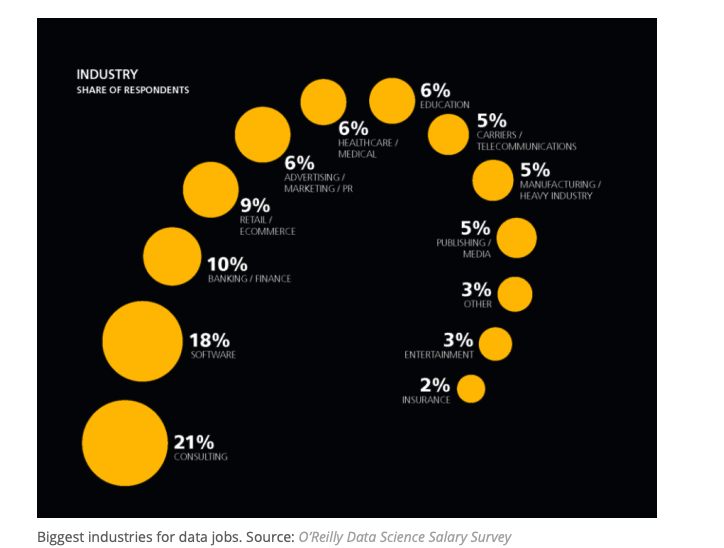

In [5]:
by_company = df_tot.groupby('Company').count().sort_values(by='Title', ascending=False)
by_company

,Title,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
Company,,,,,,,,,
Staffigo,1072,1072,1072,1072,1072,1072,1072,1072,1072
Jobs Interviewing Now from HCS,498,498,498,498,498,498,498,498,498
HiredAllied.com,455,455,455,455,455,455,455,455,455
Diverse Lynx,283,283,283,283,283,283,283,283,283
ClearedJobs.Net,277,277,277,277,277,277,277,277,277
...,...,...,...,...,...,...,...,...,...
Nityo Infotech,1,1,1,1,1,1,1,1,1
Nintendo,1,1,1,1,1,1,1,1,1
Nimbus Consulting,1,1,1,1,1,1,1,1,1


In [8]:
apple = df_tot.loc[df_tot['Company']=='Apple'].reset_index()
apple

,index,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,381,"AI/ML - Sr Data Scientist, Siri Data",Apple,"Cupertino, California, United States",2020-06-19,Not Applicable,Full-time,Consumer Electronics,SummaryDo you get excited by driving product i...,California,CA
1,386,"Data Science Senior Manager, Apple Media Products",Apple,"Cupertino, California, United States",2020-06-19,Not Applicable,Full-time,Consumer Electronics,SummaryApple is looking for a senior manager o...,California,CA
2,391,Service Reliability Engineer - AMP Analytics A...,Apple,"Cupertino, California, United States",2020-06-19,Not Applicable,Full-time,Consumer Electronics,SummaryThe Service Reliability Engineer (SRE) ...,California,CA
3,394,"Data Scientist, Apple Pay Security",Apple,"Cupertino, California, United States",2020-06-19,Not Applicable,Full-time,Consumer Electronics,SummaryJoin the team that provides software se...,California,CA
4,395,"Senior Software Engineer (Search, distributed ...",Apple,"Cupertino, California, United States",2020-06-19,Not Applicable,Full-time,Consumer Electronics,SummaryThe Apple Media Products Engineering te...,California,CA
5,396,Data Scientist Lead/Manager,Apple,"Cupertino, California, United States",2020-06-19,Not Applicable,Full-time,Consumer Electronics,SummaryWould you like to play a role in bringi...,California,CA
6,397,"Data Analytics Engineer, Health Strategic Init...",Apple,"Cupertino, California, United States",2020-06-19,Not Applicable,Full-time,Consumer Electronics,SummaryHave you ever wanted to work on somethi...,California,CA
7,527,"Data Science Senior Manager, Apple Media Products",Apple,"Cupertino, California, United States",2020-06-18,Not Applicable,Full-time,Consumer Electronics,SummaryApple is looking for a senior manager o...,California,CA
8,538,iCloud Data Science Software Engineer - Cupert...,Apple,"Cupertino, California, United States",2020-06-18,Not Applicable,Full-time,Consumer Electronics,SummaryImagine what you could do here. At Appl...,California,CA
9,547,"AI/ML - Data Engineer, Siri Data",Apple,"Cupertino, California, United States",2020-06-18,Not Applicable,Full-time,Consumer Electronics,SummaryWould you like to play a part in the ne...,California,CA


In [9]:
facebook = df_tot.loc[df_tot['Company']=='Facebook'].reset_index()
facebook

,index,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,1056,"Data Scientist, Analytics - WhatsApp Privacy",Facebook,"Menlo Park, California, United States",2020-06-11,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,California,CA
1,7649,"Data Scientist, Analytics - Recruiting Products",Facebook,"New York, New York, United States",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,New York,NY
2,7650,"Data Scientist, Instagram - Well-being, Trust",Facebook,"New York, New York, United States",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,New York,NY
3,10807,"Data Scientist, Product Analytics",Facebook,"Austin, Texas, United States",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,Texas,TX
4,12762,"Data Scientist, Analytics-Remote Presence",Facebook,"Bellevue, Washington, United States",2020-06-06,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,Washington,WA
5,12828,Linguistic Engineering Manager,Facebook,"Redmond, Washington, United States",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,Washington,WA
6,12829,Linguistic Engineer,Facebook,"Redmond, Washington, United States",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,Washington,WA
7,12830,Data Engineer,Facebook,"Seattle, Washington, United States",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,Washington,WA
8,12831,"Data Science Manager, Analytics Ads & Busine...",Facebook,"Bellevue, Washington, United States",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,Washington,WA
9,12832,"Data Scientist, Infrastructure",Facebook,"Bellevue, Washington, United States",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,Washington,WA


In [10]:
amazon = df_tot.loc[df_tot['Company']=='Amazon'].reset_index()
amazon

,index,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,188,Applied Scientist,Amazon,"Tempe, Arizona, United States",2020-06-02,Not Applicable,Full-time,"Computer Software,Information Technology and S...","DescriptionCompany: Amazon.Com Services, IncPo...",Arizona,AZ
1,208,Data Scientist,Amazon,"Tempe, Arizona, United States",2020-05-29,Not Applicable,Full-time,"Computer Software,Information Technology and S...",DescriptionMULTIPLE POSITIONS AVAILABLECompany...,Arizona,AZ
2,217,Sr Applied Scientist,Amazon,"Tempe, Arizona, United States",2020-05-27,Mid-Senior level,Full-time,"Computer Software,Information Technology and S...",DescriptionWould you like to pioneer new techn...,Arizona,AZ
3,393,Data Scientist II,Amazon,"Culver City, California, United States",2020-06-19,Mid-Senior level,Full-time,"Computer Software,Information Technology and S...",DescriptionWant to shape the future of televis...,California,CA
4,410,"Senior Frontend Engineer, Amazon SageMaker",Amazon,"Palo Alto, California, United States",2020-06-19,Mid-Senior level,Full-time,"Computer Software,Information Technology and S...",DescriptionInterested in Machine Learning? As ...,California,CA
...,...,...,...,...,...,...,...,...,...,...,...
257,13036,Sr. Applied Scientist,Amazon,"Seattle, Washington, United States",2020-05-22,Mid-Senior level,Full-time,"Computer Software,Information Technology and S...",DescriptionDo you want the excitement of exper...,Washington,WA
258,13039,Data Engineer,Amazon,"Seattle, Washington, United States",2020-05-22,Not Applicable,Full-time,"Computer Software,Information Technology and S...",DescriptionGlobal Talent Management (GTM) is c...,Washington,WA
259,13040,Sr. Data Scientist,Amazon,"Seattle, Washington, United States",2020-05-22,Mid-Senior level,Full-time,"Computer Software,Information Technology and S...",DescriptionCustomer Service Worldwide Defect E...,Washington,WA
260,13041,Sr. Technical Program Mananger,Amazon,"Seattle, Washington, United States",2020-05-22,Mid-Senior level,Full-time,"Computer Software,Information Technology and S...",DescriptionWith hundreds of millions of custom...,Washington,WA


In [11]:
google = df_tot.loc[df_tot['Company']=='Google'].reset_index()
google

,index,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,689,"Cloud Technical Solutions Engineer, Big Data",Google,"Sunnyvale, California, United States",2020-06-17,Not Applicable,Full-time,"Information Services,Internet",Note: By applying to this position your applic...,California,CA
1,690,"Cloud Technical Solutions Engineer, Big Data",Google,"San Francisco, California, United States",2020-06-17,Not Applicable,Full-time,"Information Services,Internet",Note: By applying to this position your applic...,California,CA
2,1238,"Forecasting Manager, Products and Tools and Op...",Google,"Mountain View, California, United States",2020-06-08,Not Applicable,Full-time,"Information Services,Internet",Note: By applying to this position your applic...,California,CA
3,1421,"Forecasting Manager, Products and Tools and Op...",Google,"Boulder, Colorado, United States",2020-06-09,Not Applicable,Full-time,"Information Services,Internet",Note: By applying to this position your applic...,Colorado,CO
4,4778,"Technical Curriculum Developer, Machine Learni...",Google,Greater Boston,2020-05-27,Not Applicable,Full-time,"Information Services,Internet",Note: By applying to this position your applic...,Massachusetts,MA
5,4882,"Research Scientist, Google AI (United States)",Google,"Cambridge, Massachusetts, United States",2020-05-17,Not Applicable,Full-time,"Information Services,Internet",Note: Although most of our Research Scientists...,Massachusetts,MA
6,6134,"Technical Curriculum Developer, Machine Learni...",Google,Greater Boston,2020-05-27,Not Applicable,Full-time,"Information Services,Internet",Note: By applying to this position your applic...,New Hampshire,NH
7,7960,"Marketing Data Scientist, gTech Professional S...",Google,"New York, New York, United States",2020-05-22,Not Applicable,Full-time,"Information Services,Internet",Note: By applying to this position your applic...,New York,NY
8,8032,"Research Scientist, Google AI (United States)",Google,"New York, New York, United States",2020-05-17,Not Applicable,Full-time,"Information Services,Internet",Note: Although most of our Research Scientists...,New York,NY
9,9942,"Technical Curriculum Developer, Machine Learni...",Google,Greater Boston,2020-05-27,Not Applicable,Full-time,"Information Services,Internet",Note: By applying to this position your applic...,Rhode Island,RI


In [12]:
microsoft = df_tot.loc[df_tot['Company']=='Microsoft'].reset_index()
microsoft

,index,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,3730,Education Cloud Program Manager,Microsoft,"Baltimore, Maryland, United States",2020-06-15,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Microsoft is on a mission to empower every per...,Maryland,MD
1,11102,Senior Data & Applied Scientist,Microsoft,"Austin, Texas, United States",2020-05-04,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Senior Data &amp; Applied ScientistDo you have...,Texas,TX
2,11113,Cloud Solution Architect,Microsoft,"Houston, Texas, United States",2020-05-02,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Microsoft is on a mission to empower every per...,Texas,TX
3,12509,Data & Applied Scientist 2,Microsoft,"Redmond, Washington, United States",2020-06-20,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Are you looking for opportunities to deliver i...,Washington,WA
4,12536,Principal Data Scientist Lead,Microsoft,"Redmond, Washington, United States",2020-06-19,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Do you have a passion for Data and Machine Lea...,Washington,WA
5,12549,Senior Software Engineer,Microsoft,"Redmond, Washington, United States",2020-06-18,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Office 365 is at the core of our Company’s mis...,Washington,WA
6,12573,Sr. Data & Applied Scientist,Microsoft,"Bellevue, Washington, United States",2020-06-18,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Are you interested in being part of a team wit...,Washington,WA
7,12597,Software Engineer,Microsoft,"Redmond, Washington, United States",2020-06-17,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",What if your job description were simply “Make...,Washington,WA
8,12599,Full Time Opportunities for PhD Students or Re...,Microsoft,"Redmond, Washington, United States",2020-06-17,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Data Scientists at Microsoft help to improve t...,Washington,WA
9,12620,Full Time Opportunities for Students or Recent...,Microsoft,"Redmond, Washington, United States",2020-06-16,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Data Scientists at Microsoft help to improve t...,Washington,WA


In [14]:
big_companies = pd.DataFrame()
for big_company in ['Facebook','Apple','Amazon','Google','Microsoft']:
    big_companies = big_companies.append(df_tot.loc[df_tot['Company']==big_company].reset_index())

big_companies

,index,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,1056,"Data Scientist, Analytics - WhatsApp Privacy",Facebook,"Menlo Park, California, United States",2020-06-11,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,California,CA
1,7649,"Data Scientist, Analytics - Recruiting Products",Facebook,"New York, New York, United States",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,New York,NY
2,7650,"Data Scientist, Instagram - Well-being, Trust",Facebook,"New York, New York, United States",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,New York,NY
3,10807,"Data Scientist, Product Analytics",Facebook,"Austin, Texas, United States",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,Texas,TX
4,12762,"Data Scientist, Analytics-Remote Presence",Facebook,"Bellevue, Washington, United States",2020-06-06,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,Washington,WA
...,...,...,...,...,...,...,...,...,...,...,...
34,13064,Senior Software Engineer,Microsoft,"Redmond, Washington, United States",2020-05-11,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Senior Software Engineer - Power Platform &...,Washington,WA
35,13159,Senior Data & Applied Scientist,Microsoft,"Redmond, Washington, United States",2020-04-17,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Are you looking for opportunities to deliver i...,Washington,WA
36,13161,Senior Data & Applied Scientist,Microsoft,"Bellevue, Washington, United States",2020-04-14,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",We are the Weather and Finance Services team u...,Washington,WA
37,13166,Software Engineer II,Microsoft,"Redmond, Washington, United States",2020-04-03,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Azure is Microsoft’s central cloud infrastruct...,Washington,WA


In [17]:
big_companies['Month'] = pd.DatetimeIndex(big_companies['Date']).month

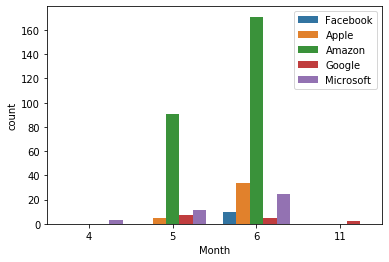

In [18]:
g = sns.countplot(x='Month', data=big_companies, hue='Company')
plt.legend(loc=1)
plt.show(g)

### Choropleth Map

In [112]:
by_state = df_tot.groupby('Code').count().sort_values(by=['Code'], ascending=True).reset_index()
by_state

,Code,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State
0,AK,7,7,7,7,7,7,7,7,7
1,AL,88,88,88,88,88,88,88,88,88
2,AR,45,45,45,45,45,45,45,45,45
3,AZ,222,222,222,222,222,222,221,222,222
4,CA,982,982,982,982,982,982,981,982,982
5,CO,265,265,265,265,265,265,265,265,265
6,CT,273,273,273,273,273,273,272,273,273
7,DE,130,130,130,130,130,130,130,130,130
8,FL,427,427,427,427,427,427,427,427,427
9,GA,1,1,1,1,1,1,1,1,1


In [113]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=by_state['Code'], # Spatial coordinates
    z = by_state['Title'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Job Posting Number",
))

fig.update_layout(
    title_text = '2020 US Data Science Jobs Exports by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

### Clean the description text data

#### stopwords

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tingtingweng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### stemming

In [5]:
from nltk.stem import SnowballStemmer # Stemmers remove morphological affixes from words, leaving only the word stem.
snow = SnowballStemmer('english') 
print(snow.stem('tasty'))
print(snow.stem('joined'))
print(snow.stem('apples'))

tasti
join
appl


#### Punctuations Removal

In [23]:
import re
# cleaning punctuations from the sentence
sentence = "I'd like to have some coffee today!"
sentence = re.sub(r'[\'|"|#]', r'', sentence) # remove these punctuation
sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
sentence

'Id like to have some coffee today '

#### combine

In [24]:
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # lower case
    sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
    tokens = sentence.split()
    #remove stopwords
    for t in tokens:
        if t in stop:
            tokens.remove(t)
    out = []
    #for t in tokens:
    #    out.append(snow.stem(t))
    out = " ".join(tokens)
    out = re.sub(r'[\'|"|#]', r'', out) # remove these punctuation
    return out

In [25]:
df_tot['Description_Clean'] = df_tot['Description'].apply(cleanup)

#### WorldClouds

In [231]:
!pip install wordcloud

     |████████████████████████████████| 163kB 513kB/s eta 0:00:01


In [26]:
from wordcloud import WordCloud, STOPWORDS

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=None,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

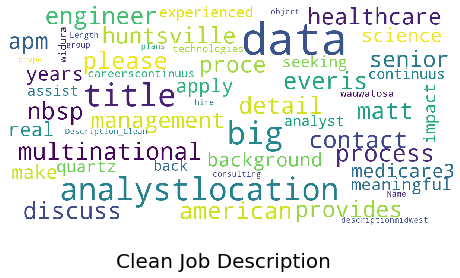

In [27]:
show_wordcloud(df_tot['Description_Clean'], title = "Clean Job Description")

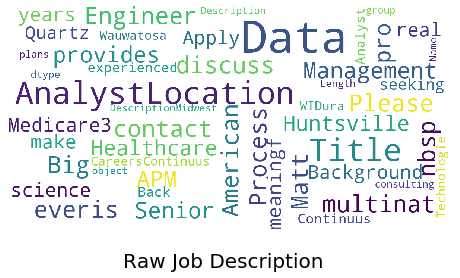

In [28]:
show_wordcloud(df_tot['Description'], title = "Raw Job Description")

### Convert text to vector

#### 1) Uni-gram BOW

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
uni_gram = CountVectorizer(min_df = 5, binary = True) # only use keyword which shows up more than 5 times. 
uni_gram_vectors = uni_gram.fit_transform(ds_jobs['description_clean'].values)

In [15]:
uni_gram_vectors.shape

(16000, 10388)

In [18]:
features = uni_gram.get_feature_names()
features[0:10]

['00',
 '000',
 '0009',
 '000ndash99',
 '0028',
 '0055',
 '00am',
 '00job',
 '00pm',
 '01']

#### 2)Bi-gram BOW

In [19]:
bi_gram = CountVectorizer(ngram_range=(1,2), min_df = 5, binary = True)
bi_gram_vectors = bi_gram.fit_transform(ds_jobs['description_clean'].values)

In [20]:
bi_gram_vectors.shape

(16000, 93199)

In [21]:
features = bi_gram.get_feature_names()
features[0:10]

['00',
 '00 am4',
 '00 am5',
 '00 annual',
 '00 hour',
 '00 pm',
 '000',
 '000 110',
 '000 175',
 '000 48']

#### 3) tf-idf

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 5)
tfidf_vectors = tfidf.fit_transform(ds_jobs['description_clean'].values)

In [44]:
tfidf_vectors.shape

(16000, 103704)

In [45]:
features = tfidf.get_feature_names()
features[0:10]

['00',
 '00 am4',
 '00 am5',
 '00 annually',
 '00 hour',
 '00 pm',
 '000',
 '000 110',
 '000 175',
 '000 48']

#### NMF (Nonnegative Matrix Factorization)

In [46]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [47]:
n_samples = 1000000
NMF_topics = 50
NMF_top_words = 15

LDA_topics = 100
LDA_top_words = 10

In [48]:
nmf = NMF(n_components=NMF_topics, init='nndsvda', random_state=1,alpha=.1, l1_ratio=.5).fit(tfidf_vectors)

In [49]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: \n" %(topic_idx+1))
        raw_list = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        weight = [str(topic[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(",".join(raw_list))
        print('\n')
        print(",".join(weight))
        print('\n')
        #print('Maximum difference: %d'%(float(weight[0])-float(weight[1])))
        #print('\n')

In [50]:
tfidf_feature_names = tfidf.get_feature_names()
print_top_words(nmf, tfidf_feature_names, NMF_top_words)

Topic #1: 

quantum,ibm,qiskit,progressive,industries,career,the,you,principles,linear,expertise,data,world,optimization,within


1.8239508409847311,1.1574021480572998,0.48524388797358153,0.47584655038523266,0.4234263572353942,0.4052350813491988,0.40144873349057464,0.3842813508556192,0.35545363748187836,0.34430125283293395,0.3271579892662338,0.32399972685783407,0.3208167793099378,0.30071185438982434,0.29327656109523814


Topic #2: 

data,the,experience,business,analytics,work,analysis,science,team,skills,ability,solutions,management,development,sql


2.474424092415632,1.0911718323766222,0.9619754214915008,0.9233809513533173,0.528561695859212,0.4995152719852054,0.45633827277127786,0.4525995296162849,0.4465236482219212,0.44003311753718927,0.4287834000938552,0.4192543774660969,0.4071499158980582,0.4001869416075207,0.3870977915832211


Topic #3: 

clinical,clinical scientist,clinical science,activities,trial,clinical development,development,assigned,therapeutic area,program,scientific,ther

front end,front,backend,angular,their customers,end,village,greenwood,greenwood village,dashboard,product,customers,acceptable,end work,working next


0.5184683595186242,0.48797457234092007,0.3575697928749422,0.3506932359512724,0.3461320816603468,0.32752010517875696,0.3077959004331784,0.3077959004331784,0.3077959004331784,0.28457569129529464,0.2712423333550349,0.243871785733564,0.22590615816082693,0.18939109789420067,0.18939109789420067


Topic #29: 

myers squibb,squibb,myers,work environment,research,bristol myers,bristol,personal,work,environment,patients,squibb global,the,lives,pursue


0.33847905454143074,0.33847905454143074,0.33815731659582676,0.33740626756110637,0.28718486655053094,0.2803477359135932,0.2803477359135932,0.22481590051310116,0.21719475670312563,0.20990053477745121,0.20283066227453883,0.17050976963895,0.1647123407426705,0.16296322080415743,0.16155180890528284


Topic #30: 

fee schedules,fee,implement changes,schedules,drg,cms,medical bill,procurement interpretation